# Tutorial 1: Geometric 3D Transformations in Beignet

This tutorial will cover the main use of these rotation operators in `beignet`:

- **Quaternions** - compact and efficient rotation representation
- **Rotation matrices** - standard matrix representation of rotations
- **Euler agles** - angle-based rotations
- **Rotation vectors** - axis-angle representation


#### Why do we care about 3D transformations in biology?

Proteins, DNA, and small molecules all function in three dimensions, and being 
able to describe and manipulate those shapes accurately is essential. 
We often need to rotate or align structures to compare them, understand
how they interact, or model how they move over time. These transformations
 show up everywhere—from analyzing how two proteins bind, to running molecular
  dynamics simulations, to figuring out how a drug fits into its target.

This tutorial will show how to use `beignet` to transform simple
3D points - in our case, a simplified glycine molecule which is the simplest amino acid and a nice molecule.


## 1. Introduction and Setup

Let's start by importing the necessary libraries and setting up our 3D points.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor

import beignet

torch.manual_seed(42)
np.random.seed(42)

We need something to rotate around.
Let's use a very simple molecule glycine.

In [ ]:
# Create molecular structure - for this tutorial,
# we're going to create a simplified glycine molecule


def create_molecule() -> tuple[Tensor, list[tuple[int, int]], dict[str, Tensor]]:
    """
    Create a simplified representation of glycine molecule structure.

    Returns
    -------
    atoms : Tensor
        Atomic coordinates (N_atoms x 3)
    bonds : list[tuple[int, int]]
        Bond connections as pairs of atom indices
    atom_types : dict[str, Tensor]
        Indices of different atom types
    """
    # Simplified approximate glycine structure coordinates
    # H2N-CH2-COOH structure

    atom_coords = torch.tensor(
        [
            # Main backbone atoms
            [0.0, 0.0, 0.0],  # 0: N (amino nitrogen)
            [1.5, 0.0, 0.0],  # 1: C (alpha carbon)
            [2.5, 1.2, 0.0],  # 2: C (carboxyl carbon)
            [3.7, 1.2, 0.0],  # 3: O (carboxyl oxygen, double bond)
            [2.0, 2.3, 0.0],  # 4: O (carboxyl oxygen, single bond)
            # Hydrogen atoms
            [-0.5, -0.8, 0.5],  # 5: H (on amino nitrogen)
            [-0.5, -0.8, -0.5],  # 6: H (on amino nitrogen)
            [1.2, -0.8, 0.8],  # 7: H (on alpha carbon)
            [1.2, -0.8, -0.8],  # 8: H (on alpha carbon)
            [1.5, 3.0, 0.0],  # 9: H (on carboxyl oxygen)
        ],
        dtype=torch.float32,
    )

    # Bond connections (atom index pairs)
    bonds = [
        # Main backbone bonds
        (0, 1),  # N-C (amino to alpha carbon)
        (1, 2),  # C-C (alpha carbon to carboxyl carbon)
        (2, 3),  # C=O (carboxyl double bond)
        (2, 4),  # C-O (carboxyl single bond)
        # Hydrogen bonds
        (0, 5),  # N-H
        (0, 6),  # N-H
        (1, 7),  # C-H
        (1, 8),  # C-H
        (4, 9),  # O-H (carboxyl OH)
    ]

    # Atom type indices
    atom_types = {
        "carbon": torch.tensor([1, 2]),
        "nitrogen": torch.tensor([0]),
        "oxygen": torch.tensor([3, 4]),
        "hydrogen": torch.tensor([5, 6, 7, 8, 9]),
    }

    return atom_coords, bonds, atom_types

In [3]:
# And let's create a function to visualize our molecule


def plot_molecule(
    atoms: Tensor,
    bonds: list[tuple[int, int]],
    atom_types: dict[str, Tensor],
    title: str = "Molecule",
    alpha: float = 0.8,
    ax: plt.Axes | None = None,
) -> plt.Axes:
    """
    Plot a molecular structure.

    Parameters
    ----------
    atoms : Tensor
        Atomic coordinates
    bonds : list[tuple[int, int]]
        Bond connections
    atom_types : dict[str, Tensor]
        Atom type indices
    title : str
        Plot title
    alpha : float
        Transparency level
    ax : plt.Axes | None
        Optional matplotlib 3D axis. If None, creates new figure.

    Returns
    -------
    ax : plt.Axes
        The matplotlib 3D axis
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")

    colors = {
        "carbon": "gray",
        "nitrogen": "blue",
        "oxygen": "red",
        "hydrogen": "white",
    }

    # Plot bonds first (so they appear behind atoms)
    for i, j in bonds:
        ax.plot(
            [atoms[i, 0], atoms[j, 0]],
            [atoms[i, 1], atoms[j, 1]],
            [atoms[i, 2], atoms[j, 2]],
            "k-",
            linewidth=2,
            alpha=alpha * 0.6,
        )

    # Plot atoms by type
    sizes = {"carbon": 150, "nitrogen": 120, "oxygen": 140, "hydrogen": 60}

    for atom_type, indices in atom_types.items():
        if len(indices) > 0:
            coords = atoms[indices]
            ax.scatter(
                coords[:, 0],
                coords[:, 1],
                coords[:, 2],
                c=colors[atom_type],
                s=sizes[atom_type],
                alpha=alpha,
                label=f"{atom_type.capitalize()}",
                edgecolors="black",
                linewidth=1,
            )

    ax.set_xlabel("X (Å)")
    ax.set_ylabel("Y (Å)")
    ax.set_zlabel("Z (Å)")
    ax.set_title(title)
    ax.legend()

    return ax

Created glycine molecule (C2H5NO2)
Number of atoms: 10
Number of bonds: 9
Atom types: ['carbon', 'nitrogen', 'oxygen', 'hydrogen']


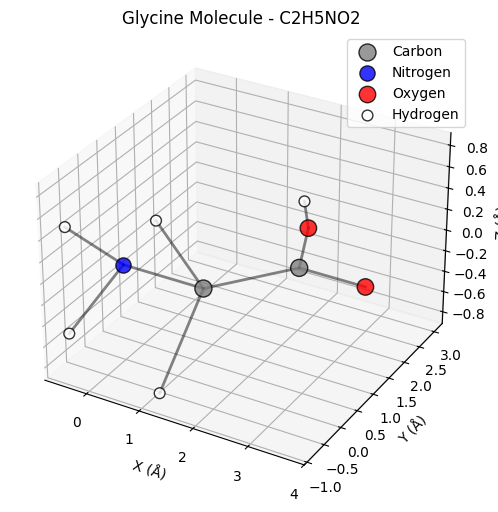

In [ ]:
# Create and visualize our molecule

atoms, bonds, atom_types = create_molecule()

print("Created glycine molecule (C2H5NO2)")
print(f"Number of atoms: {len(atoms)}")
print(f"Number of bonds: {len(bonds)}")
print(f"Atom types: {list(atom_types.keys())}")

ax = plot_molecule(atoms, bonds, atom_types, title="Glycine Molecule - C2H5NO2")

## 2. Quaternions 

**Quaternions** provides a compact, efficient way to represent rotations in 3D space. 
They are particularly useful because they avoid gimbal lock, are more efficient than 
rotation matrices for composition, and interpolate smoothly between rotations.
For example, instead of using 9 numbers to represent a rotation with rotation matrix, 
we can use use only 4 to represent it with quaternion.


### Quaternion Representation

A quaternion is represented as **q = w + xi + yj + zk**, where:
- **w** is the scalar (real) part
- **x, y, z** are the vector (imaginary) parts
- In `beignet`, quaternions are stored as `[x, y, z, w]` tensors

### Basic Quaternion Operations


In [5]:
# Create identity quaternion (no rotation)
identity_quat = beignet.quaternion_identity(1)
print("Identity quaternion [x, y, z, w]:", identity_quat)

# Create a random quaternion
random_quat = beignet.random_quaternion(1)
print("Random quaternion:", random_quat)

# Quaternion magnitude (should be 1 for unit quaternions)
magnitude = beignet.quaternion_magnitude(random_quat)
print("Quaternion magnitude:", magnitude)

# Quaternion inverse
inverse_quat = beignet.invert_quaternion(random_quat)
print("Inverse quaternion:", inverse_quat)

Identity quaternion [x, y, z, w]: tensor([[0., 0., 0., 1.]])
Random quaternion: tensor([[0.5387, 0.5587, 0.2338, 0.5857]])
Quaternion magnitude: tensor([1.8901])
Inverse quaternion: tensor([[-0.5387, -0.5587, -0.2338,  0.5857]])


Next, we can apply our quaterniions with `beignet.apply_quaternion`

Original molecule:
Center of mass: tensor([1.2600, 0.4500, 0.0000])

Rotated molecule:
Center of mass: tensor([0.7299, 0.5530, 0.9755])


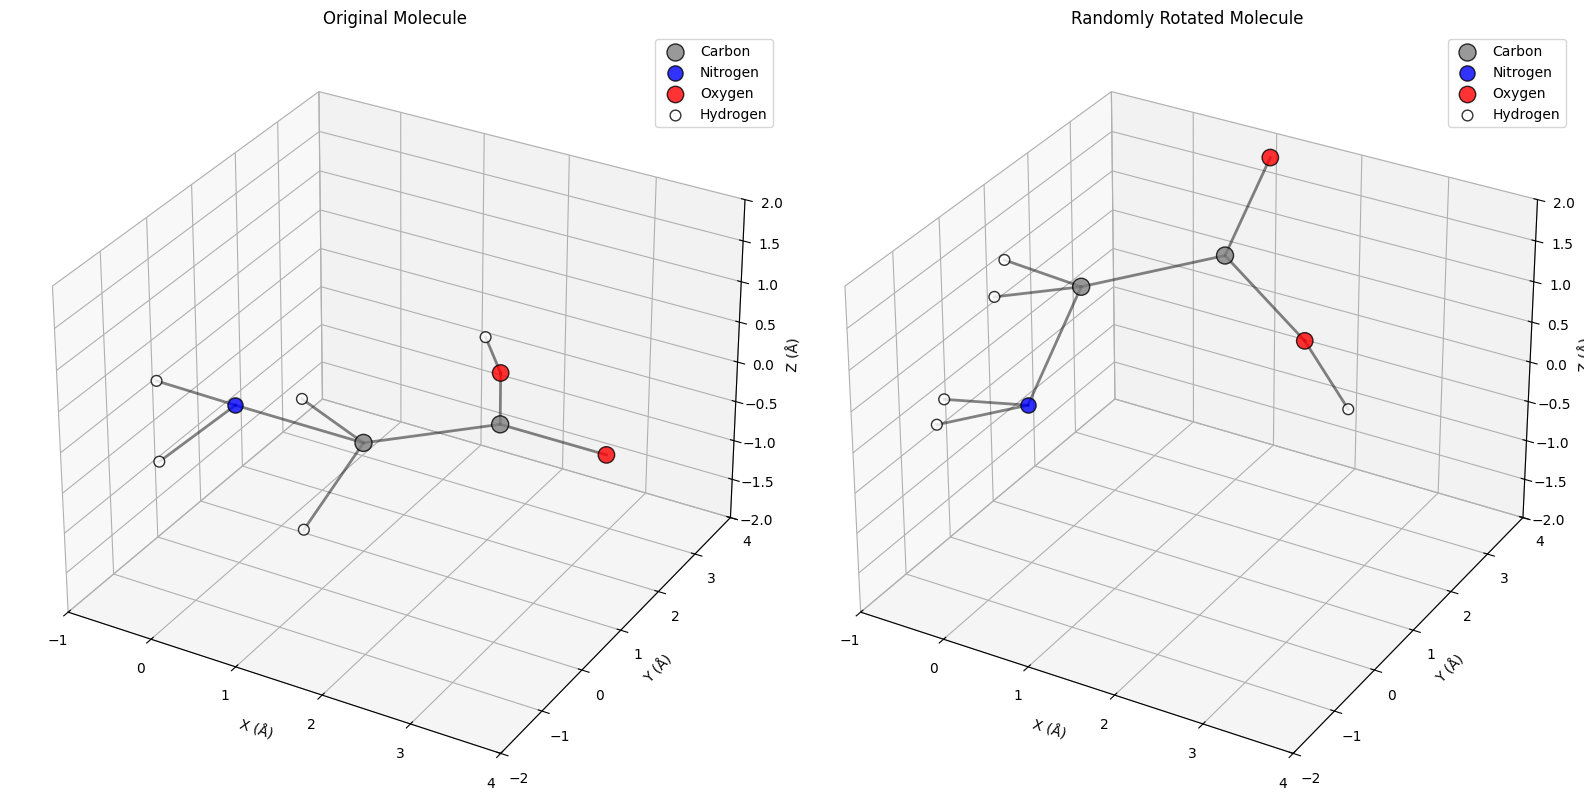

In [6]:
# Apply quaternion rotation to our molecule
rotated_atoms = beignet.apply_quaternion(atoms, random_quat)

print("Original molecule:")
print(f"Center of mass: {torch.mean(atoms, dim=0)}")
print("\nRotated molecule:")
print(f"Center of mass: {torch.mean(rotated_atoms, dim=0)}")

# Visualize the transformation
fig = plt.figure(figsize=(16, 8))

# Original molecule
ax1 = fig.add_subplot(121, projection="3d")
plot_molecule(atoms, bonds, atom_types, title="Original Molecule", ax=ax1)
ax1.set_xlim([-1, 4])
ax1.set_ylim([-2, 4])
ax1.set_zlim([-2, 2])

# Rotated molecule
ax2 = fig.add_subplot(122, projection="3d")
plot_molecule(
    rotated_atoms, bonds, atom_types, title="Randomly Rotated Molecule", ax=ax2
)
ax2.set_xlim([-1, 4])
ax2.set_ylim([-2, 4])
ax2.set_zlim([-2, 2])

plt.tight_layout()
plt.show()

You can also compose quaternions easily. 
Let's create another random rotation and compose it together

Random quaternion: tensor([[-0.5387, -0.5587, -0.2338,  0.5857]])
Another random quaternion: tensor([[0.3551, 0.5464, 0.2333, 0.7217]])
Composed quaternion: tensor([[-0.1834, -0.0405, -0.1280,  0.9738]])


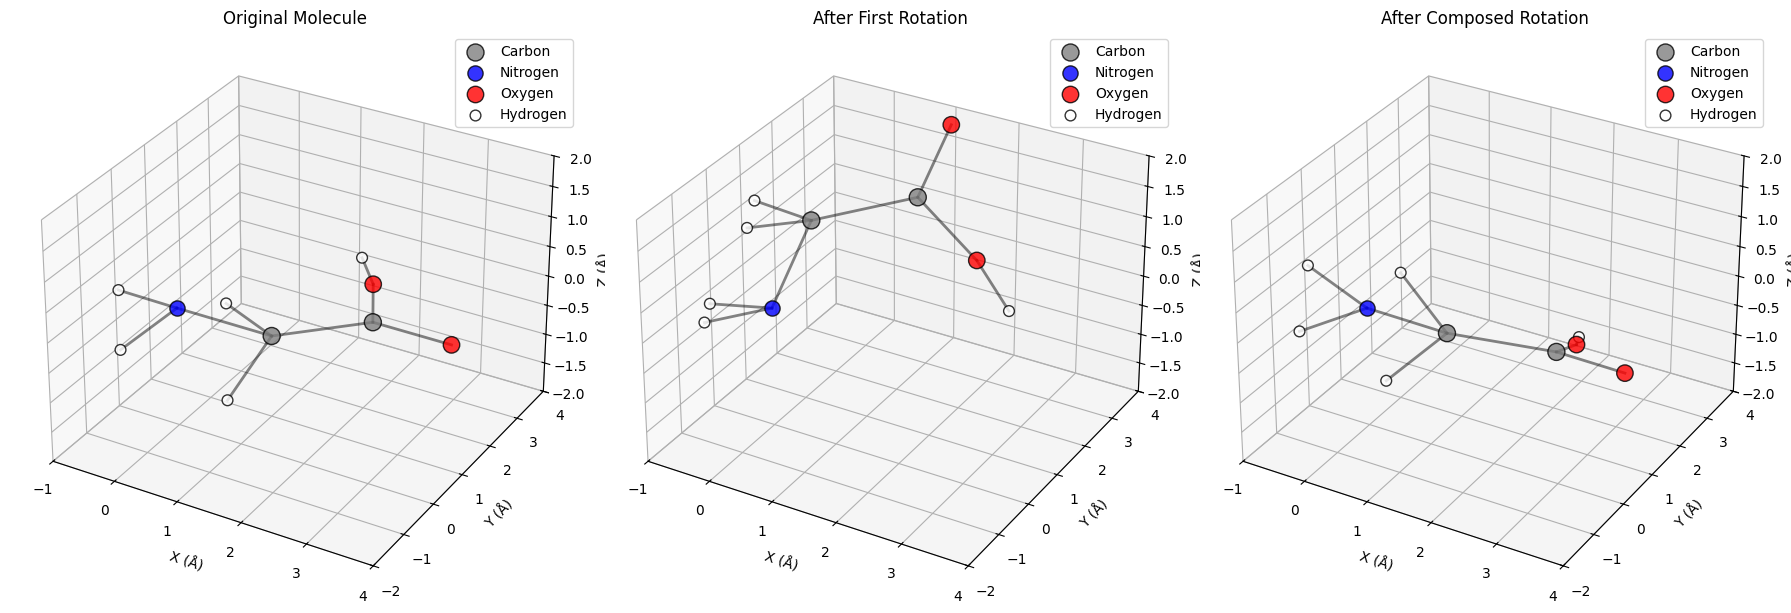

In [7]:
# Quaternion composition - combining rotations
# Let's create another rotation around the X-axis
another_random_quat = beignet.random_quaternion(1)

# Compose the rotations: first Y-rotation, then X-rotation
composed_quat = beignet.compose_quaternion(random_quat, another_random_quat)
print("Random quaternion:", random_quat)
print("Another random quaternion:", another_random_quat)
print("Composed quaternion:", composed_quat)

# Apply the composed rotation
doubly_rotated_atoms = beignet.apply_quaternion(atoms, composed_quat)

# Visualize all three states
fig = plt.figure(figsize=(18, 6))

# Original molecule
ax1 = fig.add_subplot(131, projection="3d")
plot_molecule(atoms, bonds, atom_types, title="Original Molecule", ax=ax1)
ax1.set_xlim([-1, 4])
ax1.set_ylim([-2, 4])
ax1.set_zlim([-2, 2])

# After first random rotation
ax2 = fig.add_subplot(132, projection="3d")
plot_molecule(rotated_atoms, bonds, atom_types, title="After First Rotation", ax=ax2)
ax2.set_xlim([-1, 4])
ax2.set_ylim([-2, 4])
ax2.set_zlim([-2, 2])

# After composed rotation
ax3 = fig.add_subplot(133, projection="3d")
plot_molecule(
    doubly_rotated_atoms, bonds, atom_types, title="After Composed Rotation", ax=ax3
)
ax3.set_xlim([-1, 4])
ax3.set_ylim([-2, 4])
ax3.set_zlim([-2, 2])

plt.tight_layout()
plt.show()

## 3. Rotation Matrices 

**Rotation matrices** are the traditional way to represent rotations in 3D space with 3x3 orthogonal matrices.

### Properties of Rotation Matrices:
- **Orthogonal**: R^T = R^(-1)
- **Determinant = 1**: det(R) = 1
- **Preserve distances**: ||Rx|| = ||x||
- **Preserve angles**: (Rx)·(Ry) = x·y

### Basic Rotation Matrix Operations

In [8]:
# Create identity rotation matrix
identity_matrix = beignet.rotation_matrix_identity(1)
print("Identity rotation matrix:")
print(identity_matrix)

# Create a random rotation matrix
random_matrix = beignet.random_rotation_matrix(1)
print("\nRandom rotation matrix:")
print(random_matrix)

# We can easily convert our quaternion to a rotation matrix
quat_to_matrix = beignet.quaternion_to_rotation_matrix(random_quat)
print("\nRandom rotation matrix from quaternion:")
print(quat_to_matrix)
print(f"Original quaternion: {random_quat}")


def verify_rotation_matrix_properties(matrix: Tensor) -> None:
    print("Determinant:", torch.det(matrix))
    print(
        "Is orthogonal? (R @ R.T ≈ I):",
        torch.allclose(matrix @ matrix.transpose(-1, -2), torch.eye(3), atol=1e-6),
    )


# Verify matrix properties
print("\nVerify identity matrix properties:")
verify_rotation_matrix_properties(identity_matrix)

print("\nVerify random matrix properties:")
verify_rotation_matrix_properties(random_matrix)

print("\nVerify quaternion to matrix properties:")
verify_rotation_matrix_properties(quat_to_matrix)

Identity rotation matrix:
tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])

Random rotation matrix:
tensor([[[ 0.1626, -0.4035,  0.9004],
         [ 0.6390, -0.6523, -0.4077],
         [ 0.7518,  0.6416,  0.1518]]])

Random rotation matrix from quaternion:
tensor([[[ 0.2665,  0.8757, -0.4026],
         [ 0.3281,  0.3104,  0.8922],
         [ 0.9063, -0.3698, -0.2046]]])
Original quaternion: tensor([[-0.5387, -0.5587, -0.2338,  0.5857]])

Verify identity matrix properties:
Determinant: tensor([1.])
Is orthogonal? (R @ R.T ≈ I): True

Verify random matrix properties:
Determinant: tensor([1.0000])
Is orthogonal? (R @ R.T ≈ I): True

Verify quaternion to matrix properties:
Determinant: tensor([1.])
Is orthogonal? (R @ R.T ≈ I): True


Matrix rotation result:
Original molecule center: tensor([1.2600, 0.4500, 0.0000])
Rotated molecule center: tensor([0.7299, 0.5530, 0.9755])

Are quaternion and matrix results the same? True


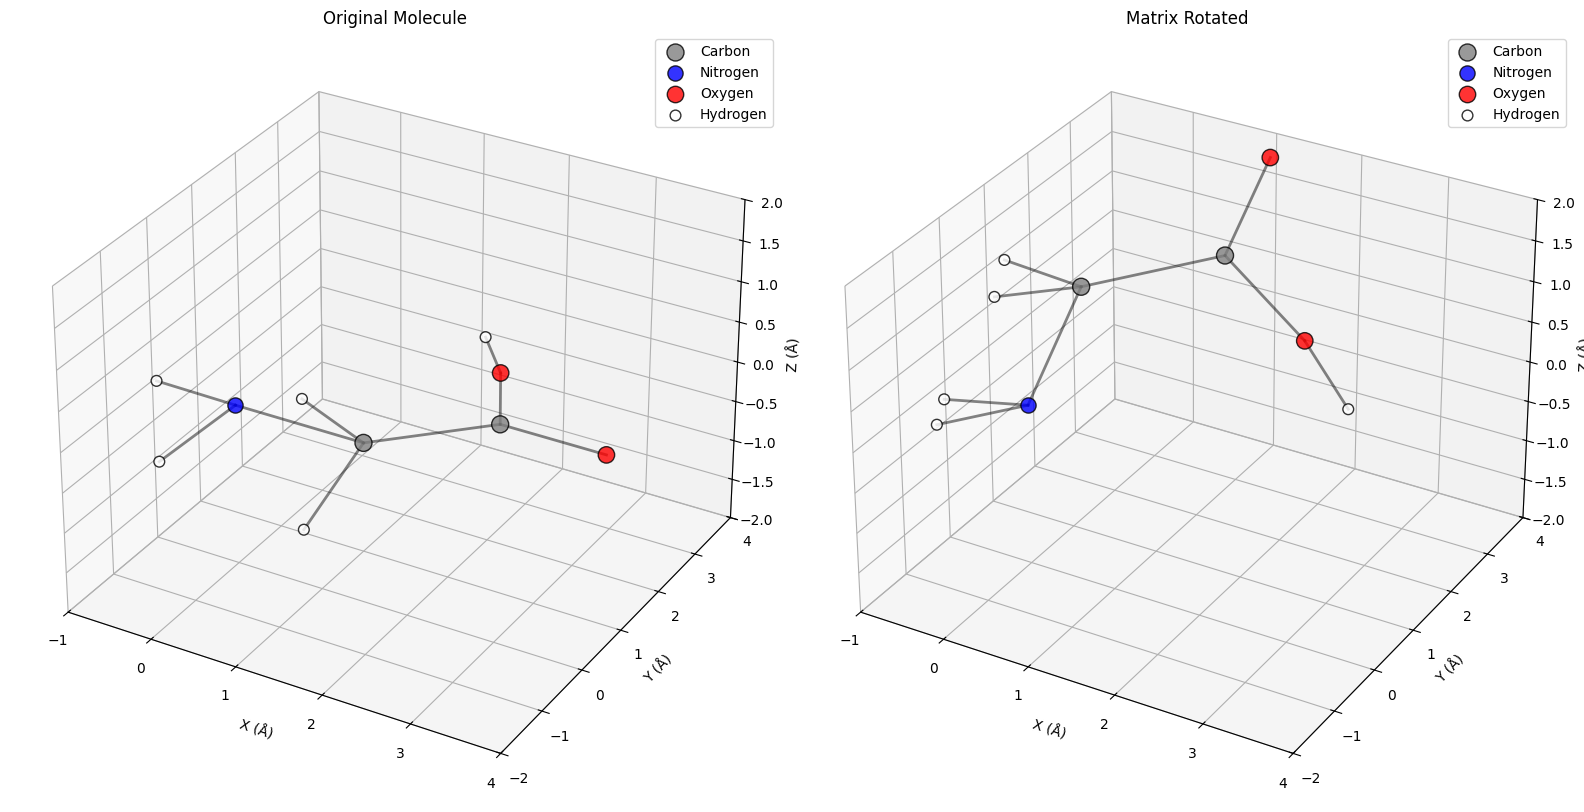

In [9]:
# Apply rotation matrix to molecule
matrix_rotated_atoms = beignet.apply_rotation_matrix(atoms, quat_to_matrix)

print("Matrix rotation result:")
print(f"Original molecule center: {torch.mean(atoms, dim=0)}")
print(f"Rotated molecule center: {torch.mean(matrix_rotated_atoms, dim=0)}")

# Compare with quaternion result
quat_result = beignet.apply_quaternion(atoms, random_quat)
matrix_result = beignet.apply_rotation_matrix(atoms, quat_to_matrix)
print(
    "\nAre quaternion and matrix results the same?",
    torch.allclose(quat_result, matrix_result, atol=1e-6),
)

# Visualize the Z-rotation
fig = plt.figure(figsize=(16, 8))

# Original molecule
ax1 = fig.add_subplot(121, projection="3d")
plot_molecule(atoms, bonds, atom_types, title="Original Molecule", ax=ax1)
ax1.set_xlim([-1, 4])
ax1.set_ylim([-2, 4])
ax1.set_zlim([-2, 2])

# Matrix rotated molecule
ax2 = fig.add_subplot(122, projection="3d")
plot_molecule(matrix_rotated_atoms, bonds, atom_types, title="Matrix Rotated", ax=ax2)
ax2.set_xlim([-1, 4])
ax2.set_ylim([-2, 4])
ax2.set_zlim([-2, 2])

plt.tight_layout()
plt.show()

To compose matrix rotations, use you can similarly use `beignet.compose_rotation_matrix`.

## 4. Euler Angles 

**Euler angles** represent rotations using three angles that describe rotations around specific axes.

### Euler Angle Conventions:
- **Intrinsic rotations**: Rotations about the moving coordinate system (e.g., 'XYZ')
- **Extrinsic rotations**: rotations about the fixed coordinate system (e.g., 'xyz')
- **Common conventions**: 'XYZ', 'ZYZ', 'ZXZ', etc.

### Working with Euler Angles


In [10]:
# Createeuler angles for 60° rotation around X-axis, 30° around Y-axis, 45° around Z-axis
# Using 'XYZ' convention: [rotation_x, rotation_y, rotation_z]
euler_angles = torch.tensor([[60.0, 30.0, 45.0]], dtype=torch.float32)  # degrees
print("Euler angles (XYZ convention):", euler_angles, "degrees")
print("In radians:", torch.deg2rad(euler_angles))

# Apply rotation
euler_rotated_atoms = beignet.apply_euler_angle(
    atoms, euler_angles, axes="XYZ", degrees=True
)
print("\nEuler angle rotation result:")
print(f"Original center: {torch.mean(atoms, dim=0)}")
print(f"Rotated center: {torch.mean(euler_rotated_atoms, dim=0)}")

# Convert between representations
quat_from_euler = beignet.euler_angle_to_quaternion(
    euler_angles, axes="XYZ", degrees=True
)
matrix_from_euler = beignet.euler_angle_to_rotation_matrix(
    euler_angles, axes="XYZ", degrees=True
)

print("\nConversions from Euler angles:")
print("To quaternion:", quat_from_euler)
print("To rotation matrix:")
print(matrix_from_euler)

# Try it with different input methods
euler_radians = torch.deg2rad(euler_angles)
euler_rotated_rad = beignet.apply_euler_angle(
    atoms, euler_radians, axes="XYZ", degrees=False
)
print("\nUsing radians vs degrees:")
print(
    "Are results the same?",
    torch.allclose(euler_rotated_atoms, euler_rotated_rad, atol=1e-6),
)

Euler angles (XYZ convention): tensor([[60., 30., 45.]]) degrees
In radians: tensor([[1.0472, 0.5236, 0.7854]])

Euler angle rotation result:
Original center: tensor([1.2600, 0.4500, 0.0000])
Rotated center: tensor([0.4960, 0.8526, 0.9040])

Conversions from Euler angles:
To quaternion: tensor([[0.5320, 0.0223, 0.4397, 0.7233]])
To rotation matrix:
tensor([[[ 0.6124, -0.6124,  0.5000],
         [ 0.6597,  0.0474, -0.7500],
         [ 0.4356,  0.7891,  0.4330]]])

Using radians vs degrees:
Are results the same? True


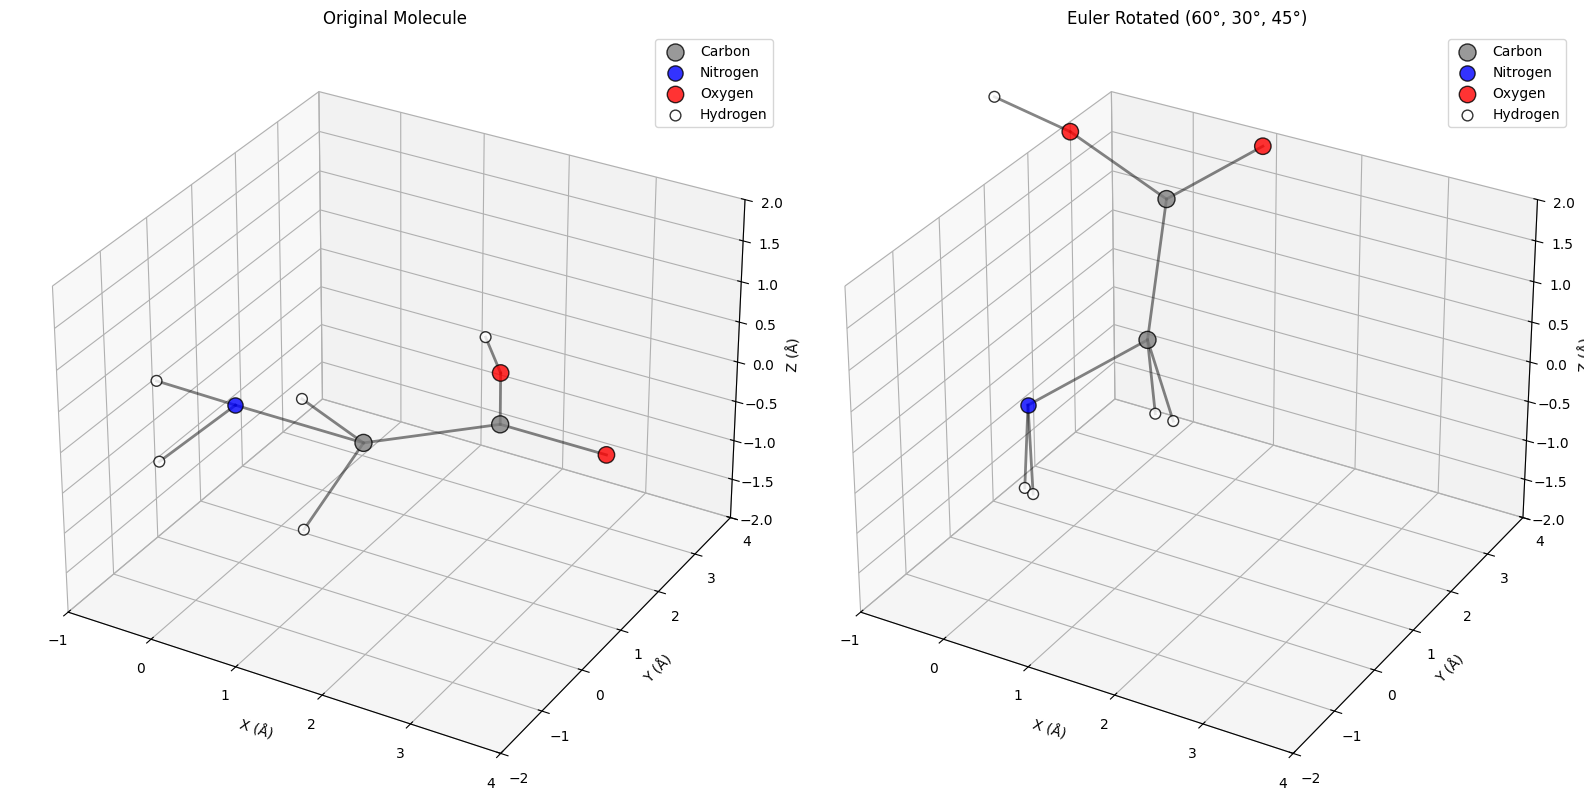

In [11]:
# Visualize  Euler rotation
fig = plt.figure(figsize=(16, 8))

# Original molecule
ax1 = fig.add_subplot(121, projection="3d")
plot_molecule(atoms, bonds, atom_types, title="Original Molecule", ax=ax1)
ax1.set_xlim([-1, 4])
ax1.set_ylim([-2, 4])
ax1.set_zlim([-2, 2])

# Euler rotated molecule
ax2 = fig.add_subplot(122, projection="3d")
plot_molecule(
    euler_rotated_atoms,
    bonds,
    atom_types,
    title="Euler Rotated (60°, 30°, 45°)",
    ax=ax2,
)
ax2.set_xlim([-1, 4])
ax2.set_ylim([-2, 4])
ax2.set_zlim([-2, 2])

plt.tight_layout()
plt.show()

Different Euler angle conventions for the same angles (45°, 60°, 30°):
XYZ: N atom tensor([0., 0., 0.]) → tensor([0., 0., 0.])
ZYX: N atom tensor([0., 0., 0.]) → tensor([0., 0., 0.])
YXZ: N atom tensor([0., 0., 0.]) → tensor([0., 0., 0.])


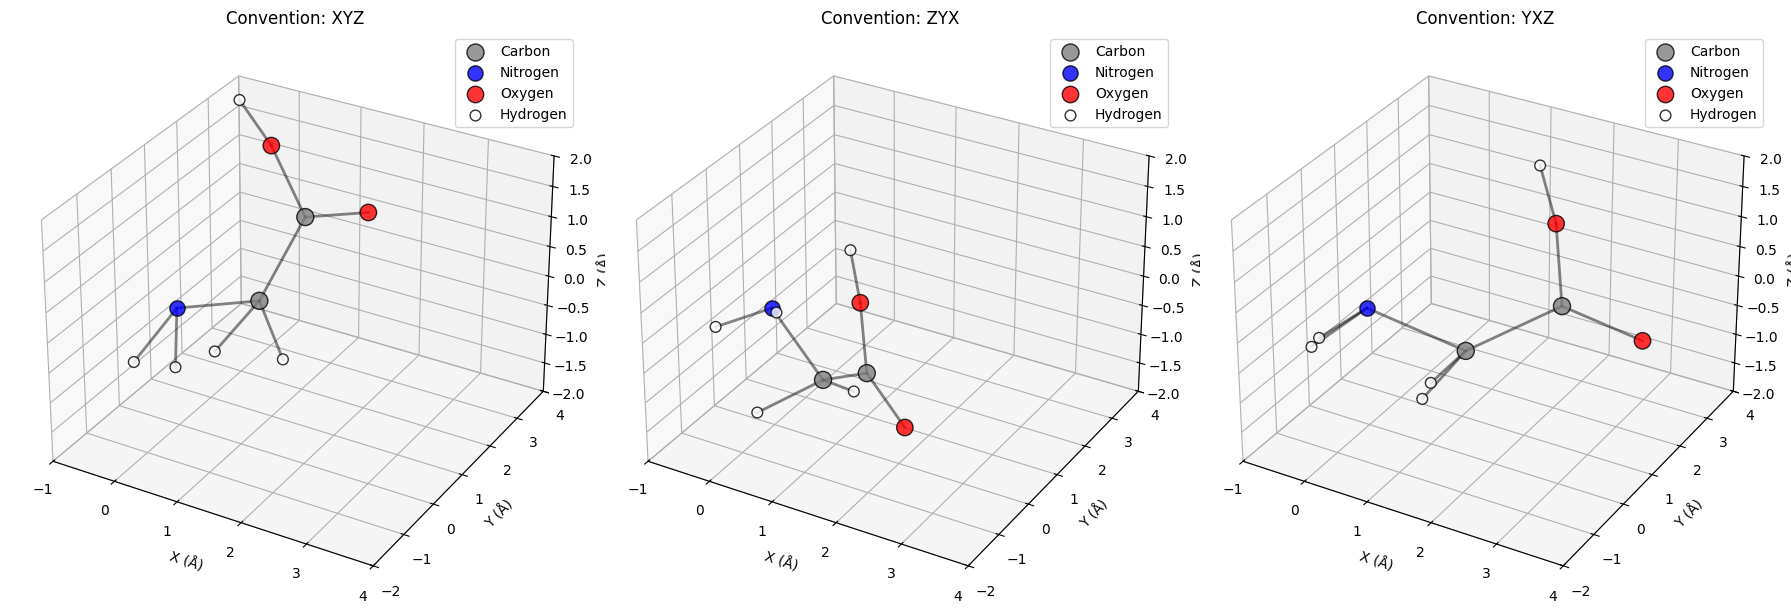

In [12]:
# Try outt different Euler angle conventions
conventions = ["XYZ", "ZYX", "YXZ"]
test_angles = torch.tensor([[45.0, 60.0, 30.0]], dtype=torch.float32)  # degrees

print("Different Euler angle conventions for the same angles (45°, 60°, 30°):")

fig = plt.figure(figsize=(18, 6))

for i, convention in enumerate(conventions):
    rotated_atoms_conv = beignet.apply_euler_angle(
        atoms, test_angles, axes=convention, degrees=True
    )

    # Show how the first atom (N) is transformed
    print(f"{convention}: N atom {atoms[0]} → {rotated_atoms_conv[0]}")

    # Plot
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    plot_molecule(
        rotated_atoms_conv, bonds, atom_types, title=f"Convention: {convention}", ax=ax
    )
    ax.set_xlim([-1, 4])
    ax.set_ylim([-2, 4])
    ax.set_zlim([-2, 2])

plt.tight_layout()
plt.show()

## 5. Rotation Vectors 

**Rotation vectors** (axis-angle representation) represent rotations using a 3D vector where:
- **Direction* indicates the axis of rotation
- **Magnitude** indicates the angle of rotation

### Working with Rotation Vectors


In [13]:
# Create random rotation vector
rotation_vector = beignet.random_rotation_vector(1)

print("Random rotation vector:", rotation_vector)
print("Magnitude:", torch.norm(rotation_vector, dim=-1))
print("Direction:", rotation_vector / torch.norm(rotation_vector, dim=-1, keepdim=True))

# Apply rotation vector in
rotvec_rotated_atoms = beignet.apply_rotation_vector(atoms, rotation_vector)
print("\nRotation vector result:")
print(f"Original center: {torch.mean(atoms, dim=0)}")
print(f"Rotated center: {torch.mean(rotvec_rotated_atoms, dim=0)}")

# Convert to other representations
quat_from_rotvec = beignet.rotation_vector_to_quaternion(rotation_vector)
matrix_from_rotvec = beignet.rotation_vector_to_rotation_matrix(rotation_vector)
euler_from_rotvec = beignet.rotation_vector_to_euler_angle(rotation_vector, axes="XYZ")

print("\nConversions from rotation vector:")
print("To quaternion:", quat_from_rotvec)
print("To Euler angles:", euler_from_rotvec)
print("To rotation matrix:", matrix_from_rotvec)

Random rotation vector: tensor([[1.6985, 1.1091, 1.4478]])
Magnitude: tensor([2.4922])
Direction: tensor([[0.6815, 0.4450, 0.5809]])

Rotation vector result:
Original center: tensor([1.2600, 0.4500, 0.0000])
Rotated center: tensor([0.1349, 0.9308, 0.9515])

Conversions from rotation vector:
To quaternion: tensor([[0.6459, 0.4218, 0.5506, 0.3190]])
To Euler angles: tensor([[-2.8731,  1.3723, -1.3773]])
To rotation matrix: tensor([[[ 0.0379,  0.1936,  0.9804],
         [ 0.8961, -0.4407,  0.0523],
         [ 0.4421,  0.8766, -0.1902]]])


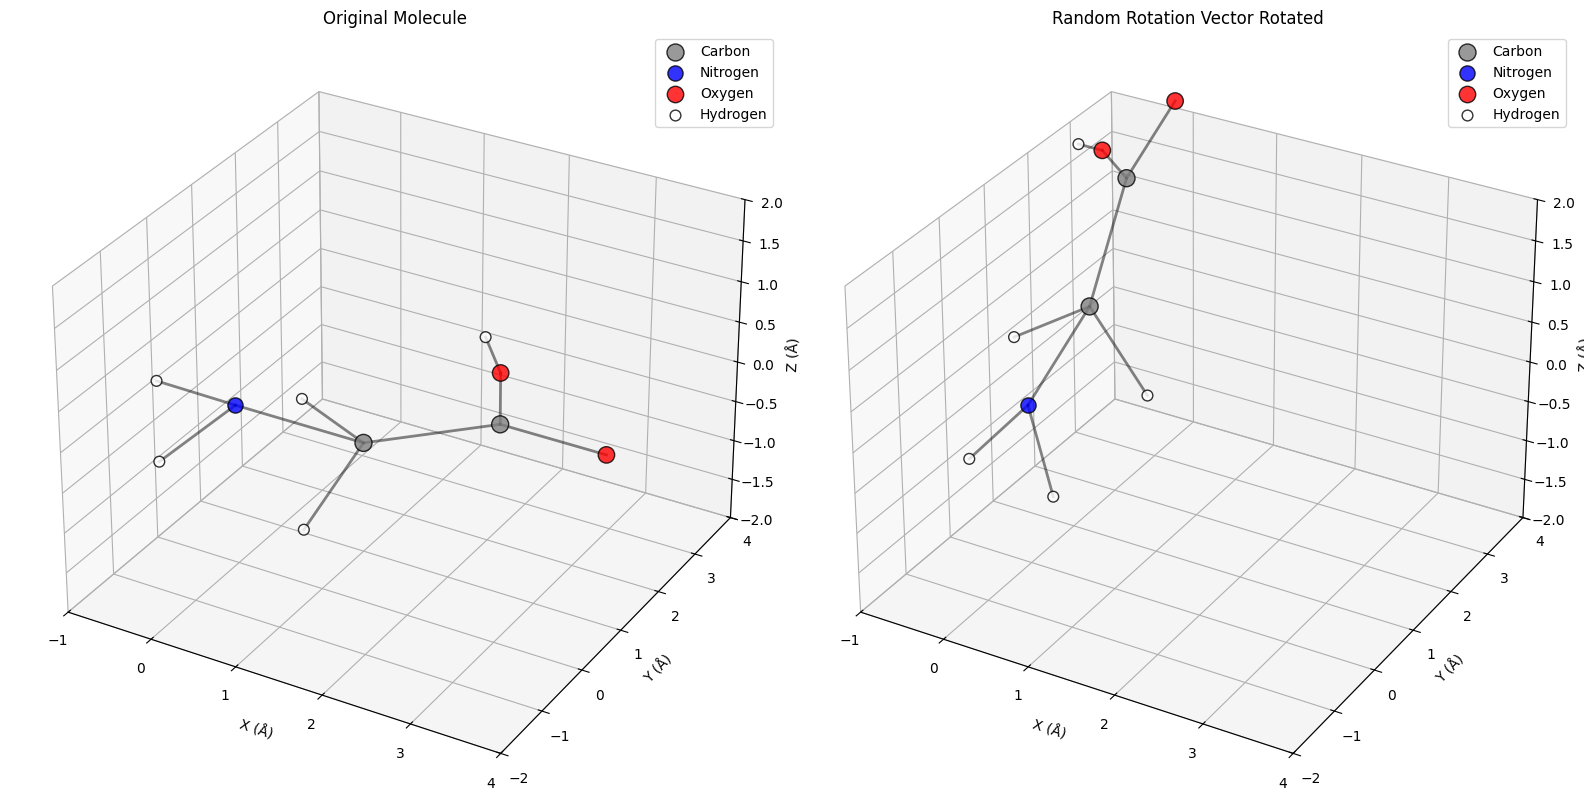

Verification that all representations give the same result:
RotVec vs Quaternion: True
RotVec vs Matrix: True


In [15]:
# Visualize the random rotation vector transformation
fig = plt.figure(figsize=(16, 8))

# Original molecule
ax1 = fig.add_subplot(121, projection="3d")
plot_molecule(atoms, bonds, atom_types, title="Original Molecule", ax=ax1)
ax1.set_xlim([-1, 4])
ax1.set_ylim([-2, 4])
ax1.set_zlim([-2, 2])

# Rotation vector rotated molecule
ax2 = fig.add_subplot(122, projection="3d")
plot_molecule(
    rotvec_rotated_atoms,
    bonds,
    atom_types,
    title="Random Rotation Vector Rotated",
    ax=ax2,
)
ax2.set_xlim([-1, 4])
ax2.set_ylim([-2, 4])
ax2.set_zlim([-2, 2])

plt.tight_layout()
plt.show()

# Verify all representations give the same result
quat_result = beignet.apply_quaternion(atoms, quat_from_rotvec)
matrix_result = beignet.apply_rotation_matrix(atoms, matrix_from_rotvec)

print("Verification that all representations give the same result:")
print(
    "RotVec vs Quaternion:",
    torch.allclose(rotvec_rotated_atoms, quat_result, atol=1e-5),
)
print(
    "RotVec vs Matrix:", torch.allclose(rotvec_rotated_atoms, matrix_result, atol=1e-5)
)